In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SIM_STEPS = 200

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Folders
BINARY_FOLDER = "../Data200x200_withinfo"
UNIFORM_FOLDER = "../Uniform200x200withInfo"

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)




torch.manual_seed(123); np.random.seed(123)

# Pre-define steps and points to maintain a consistent validation set
val_steps = np.random.randint(1,199,(val_sims.shape[0],))
val_points = np.random.randint(0,149,(val_sims.shape[0],2))
val_type = np.random.randint(0,2,(val_sims.shape[0],))




# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out







# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)
# Dataset used
# Dataset used
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True,            # if True, mask is deterministic and noise is 0
                 future_delta=0
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask
        self.future_delta = future_delta

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

        
        
    # helper function used to turn segments (0, 1) into points on the H-W grid
    def _segments_to_indices(self, segments, N, pad=0):
        idxs = []
        for a, b in segments:
            # map fraction [0,1] to pixel indices [0, N-1]
            i0 = max(pad, int(round(a * (N - 1))))
            i1 = min((N - 1) - pad, int(round(b * (N - 1))))
            if i1 >= i0:
                idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
        if not idxs:
            # full range if nothing provided
            return torch.arange(pad, N - pad, dtype=torch.long)
        return torch.unique(torch.cat(idxs)).to(torch.long)
    

    def __getitem__(self, index):
        
        # --- In Progress --- 

        #     # pick a valid step
        # if not isinstance(self.steps, np.ndarray):
        #     max_start = SIM_STEPS - 1 - self.future_delta  # ensures step + delta ≤ 199
        #     step = np.random.randint(1, max_start + 1)  
        # else:
        #     step = int(self.steps[index])
        #     max_start = SIM_STEPS - 1 - self.future_delta
        #     if step > max_start:
        #         step = max_start



        if not type(self.steps) == np.ndarray:
            step = np.random.randint(1,200)
        else:
            step = self.steps[index]

        # Create tensor for the target
        t_cur = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t_cur)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":
            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1]

            row_allowed = self._segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = self._segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))

            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))


            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)


            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]


            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk

        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t_cur[chans].clone()
        # Add noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)


        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))



        # --- In Progress --- 

        # if self.future_delta > 0:
        #     step_f = step + self.future_delta   
        #     t_label = torch.tensor(get_all(self.sims[index], step_f), dtype=torch.float32)
        # else:
        #     t_label = t_cur

        t_label = t_cur






        if self.return_mask:
            return z,t_label, mask
        else:  
            return z,t_label
    
    def __len__(self):
        return self.sims.shape[0]
    
train_loader = torch.utils.data.DataLoader(MaskedDataset(train_sims,
                                                         reveal_strategy="disks",
                                                         n_points=12,
                                                         radius=5,
                                                         mixed=True),
                                                         batch_size=8, shuffle=True)

In [ ]:
torch.manual_seed(321); np.random.seed(321)

def vis(tensor):
    return tensor.cpu().detach().numpy()

def show_evaluation_future(model, indices, val_data, delta=None):
    """
    Column 1-3: K channel  [ Given t, Predicted t+Δ, Actual t+Δ ]
    Column 4-6: P channel  [ Given t, Predicted t+Δ, Actual t+Δ ]
    """
    fig, axs = plt.subplots(len(indices), 6, dpi=400)

    # Title row
    d_txt = f" (Δ={delta})" if delta is not None else ""
    axs[0,0].set_title(f"Given K @ t", fontsize=8)
    axs[0,1].set_title(f"Pred K @ t+Δ{d_txt}", fontsize=8)
    axs[0,2].set_title(f"Actual K @ t+Δ", fontsize=8)

    axs[0,3].set_title(f"Given P @ t", fontsize=8)
    axs[0,4].set_title(f"Pred P @ t+Δ{d_txt}", fontsize=8)
    axs[0,5].set_title(f"Actual P @ t+Δ", fontsize=8)

    for i, e in enumerate(indices):
        z, t_label = val_data[e] 

        # forward pass
        out = model(z.to(device).unsqueeze(0))[0]

        # K channel
        axs[i,0].imshow(vis(z[0]),        cmap='gray', vmin=0, vmax=255)   # Given K @ t
        axs[i,1].imshow(vis(out[0]),      cmap='gray', vmin=0, vmax=255)   # Pred K @ t+Δ
        axs[i,2].imshow(vis(t_label[0]),  cmap='gray', vmin=0, vmax=255)   # Actual K @ t+Δ

        # P channel
        axs[i,3].imshow(vis(z[1]),        cmap='gray', vmin=0, vmax=255)   # Given P @ t
        axs[i,4].imshow(vis(out[1]),      cmap='gray', vmin=0, vmax=255)   # Pred P @ t+Δ
        axs[i,5].imshow(vis(t_label[1]),  cmap='gray', vmin=0, vmax=255)   # Actual P @ t+Δ

    for ax in fig.get_axes():
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [ ]:
def plot(path, name):
    cur  = np.load(f"{path}curves_{name}.npz")
    meta = np.load(f"{path}meta_{name}.npz", allow_pickle=True)

    reveal_strategy = str(meta["reveal_strategy"])
    n_points = int(meta["n_points"]); radius = int(meta["radius"]); noise = float(meta["noise"])
    channels = str(meta["channels"])
    val_steps  = meta["val_steps"]
    val_points = meta["val_points"]
    reveal_dim = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]

    # delta if you saved it; otherwise None
    delta = int(meta["future_delta"]) if "future_delta" in meta.files else None

    torch.manual_seed(123); np.random.seed(123)

    val_data = MaskedDataset(
        val_sims,
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=val_points,
        steps=val_steps,
        reveal_dim=reveal_dim
    )

    model = torch.load(f"{path}{name}.pt", weights_only=False, map_location=torch.device("cpu")).to(device)
    model.eval()

    # Show a few examples
    show_evaluation_future(model, [9, 2, 12, 17], val_data, delta=delta)

Same tests from **`pinn_for_prediction_disk_loader.ipynb`**.

In [21]:
# Test group: effect of future_delta on learning
# Stable masking (moderate coverage), moderate noise, nondeterministic mask

tests = [
    # Short-term prediction (1-step ahead)
    {"name":"delta_1_short",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":1},

    # Medium-term (5 steps ahead)
    {"name":"delta_5_medium",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":5},

    # Long-term (10 steps ahead)
    {"name":"delta_10_long",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":10},

    # Very long-term (20 steps ahead)
    {"name":"delta_20_verylong",
     "reveal_strategy":"disks", "n_points":16, "radius":5,
     "mixed":True, "noise":5,
     "deterministic_mask":False, "jitter_std":0.02,
     "future_delta":20},
]

Rest is testing already trained models

In [ ]:
# def get_files_in_folder(folder_path):
#     file_paths = []
#     for item_name in os.listdir(folder_path):
#         item_path = os.path.join(folder_path, item_name)
#         if os.path.isfile(item_path):
#             file_paths.append(item_path)
#     return file_paths

# all_files = get_files_in_folder("run_metrics")
# for test in all_files:
#     test = test[:-3]
#     path = test[0:12]
#     print(test)
# print(len(all_files))

In [23]:
path = ""
all_files = ["delta_1_short", "delta_5_medium", "delta_10_long", "delta_20_verylong", "delta_40_verylong", "delta_60_verylong"]

Generate the plots for each trained model

delta_1_short   L


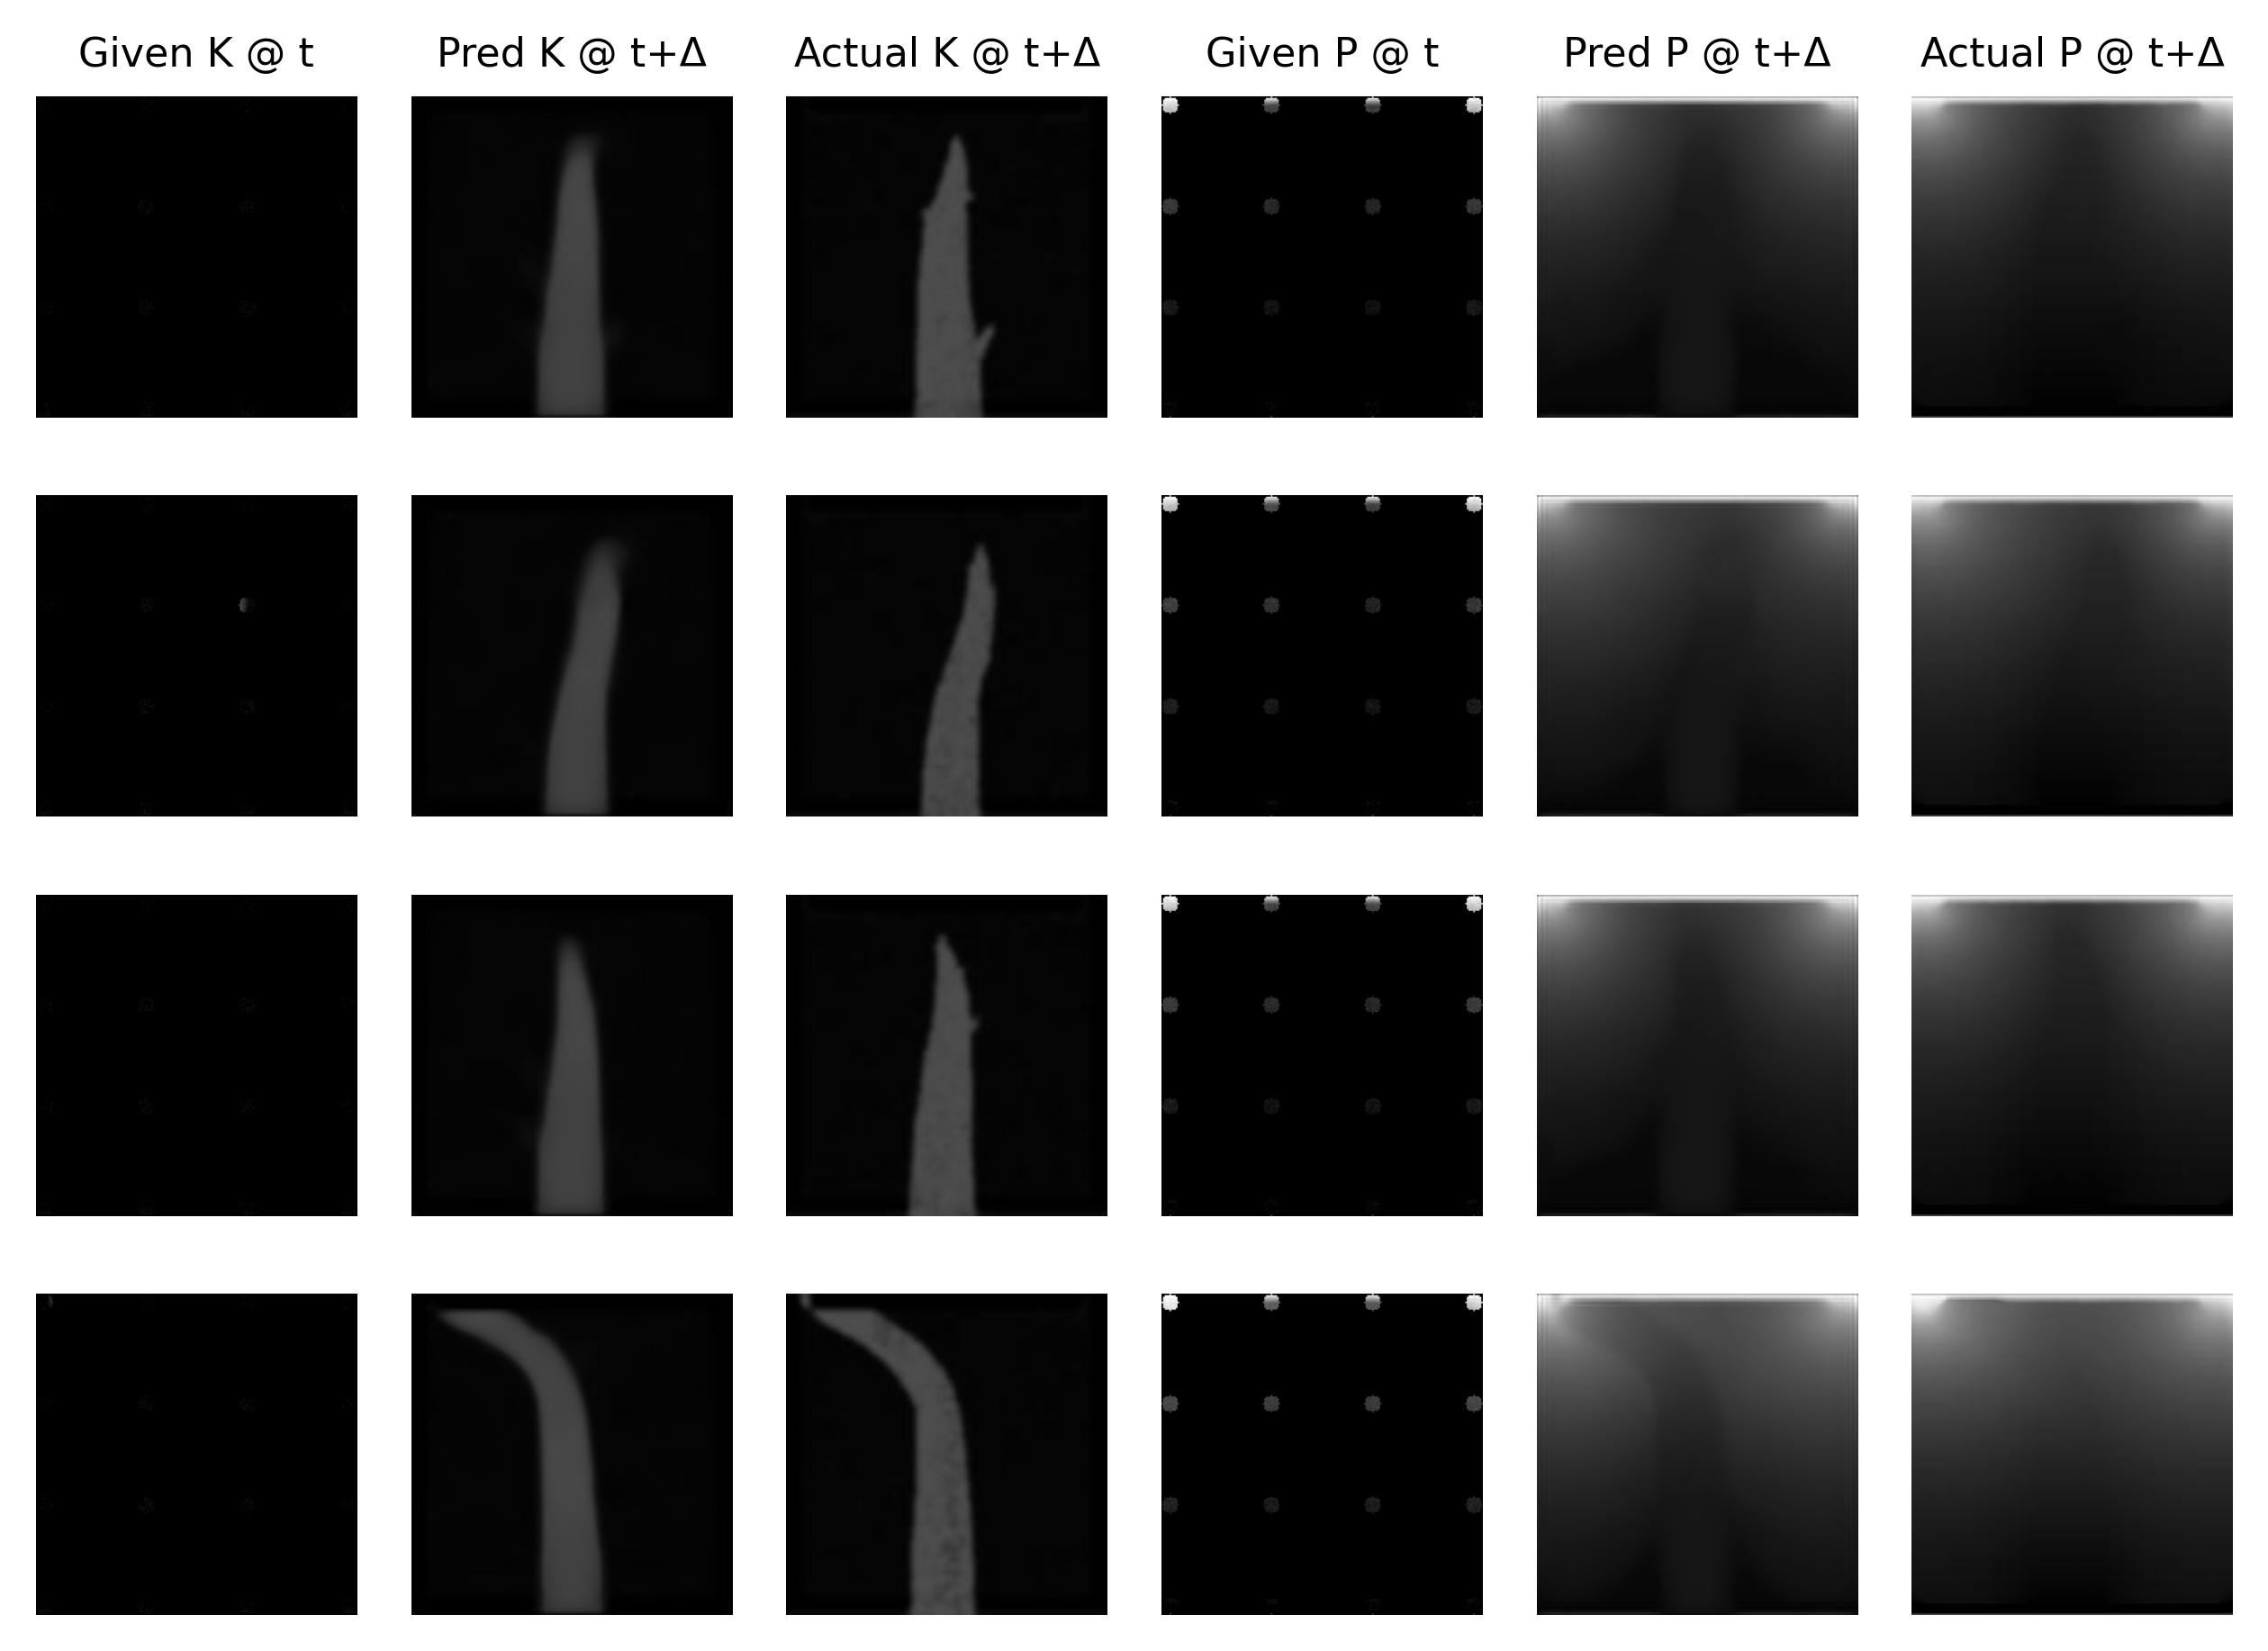

delta_5_medium   L


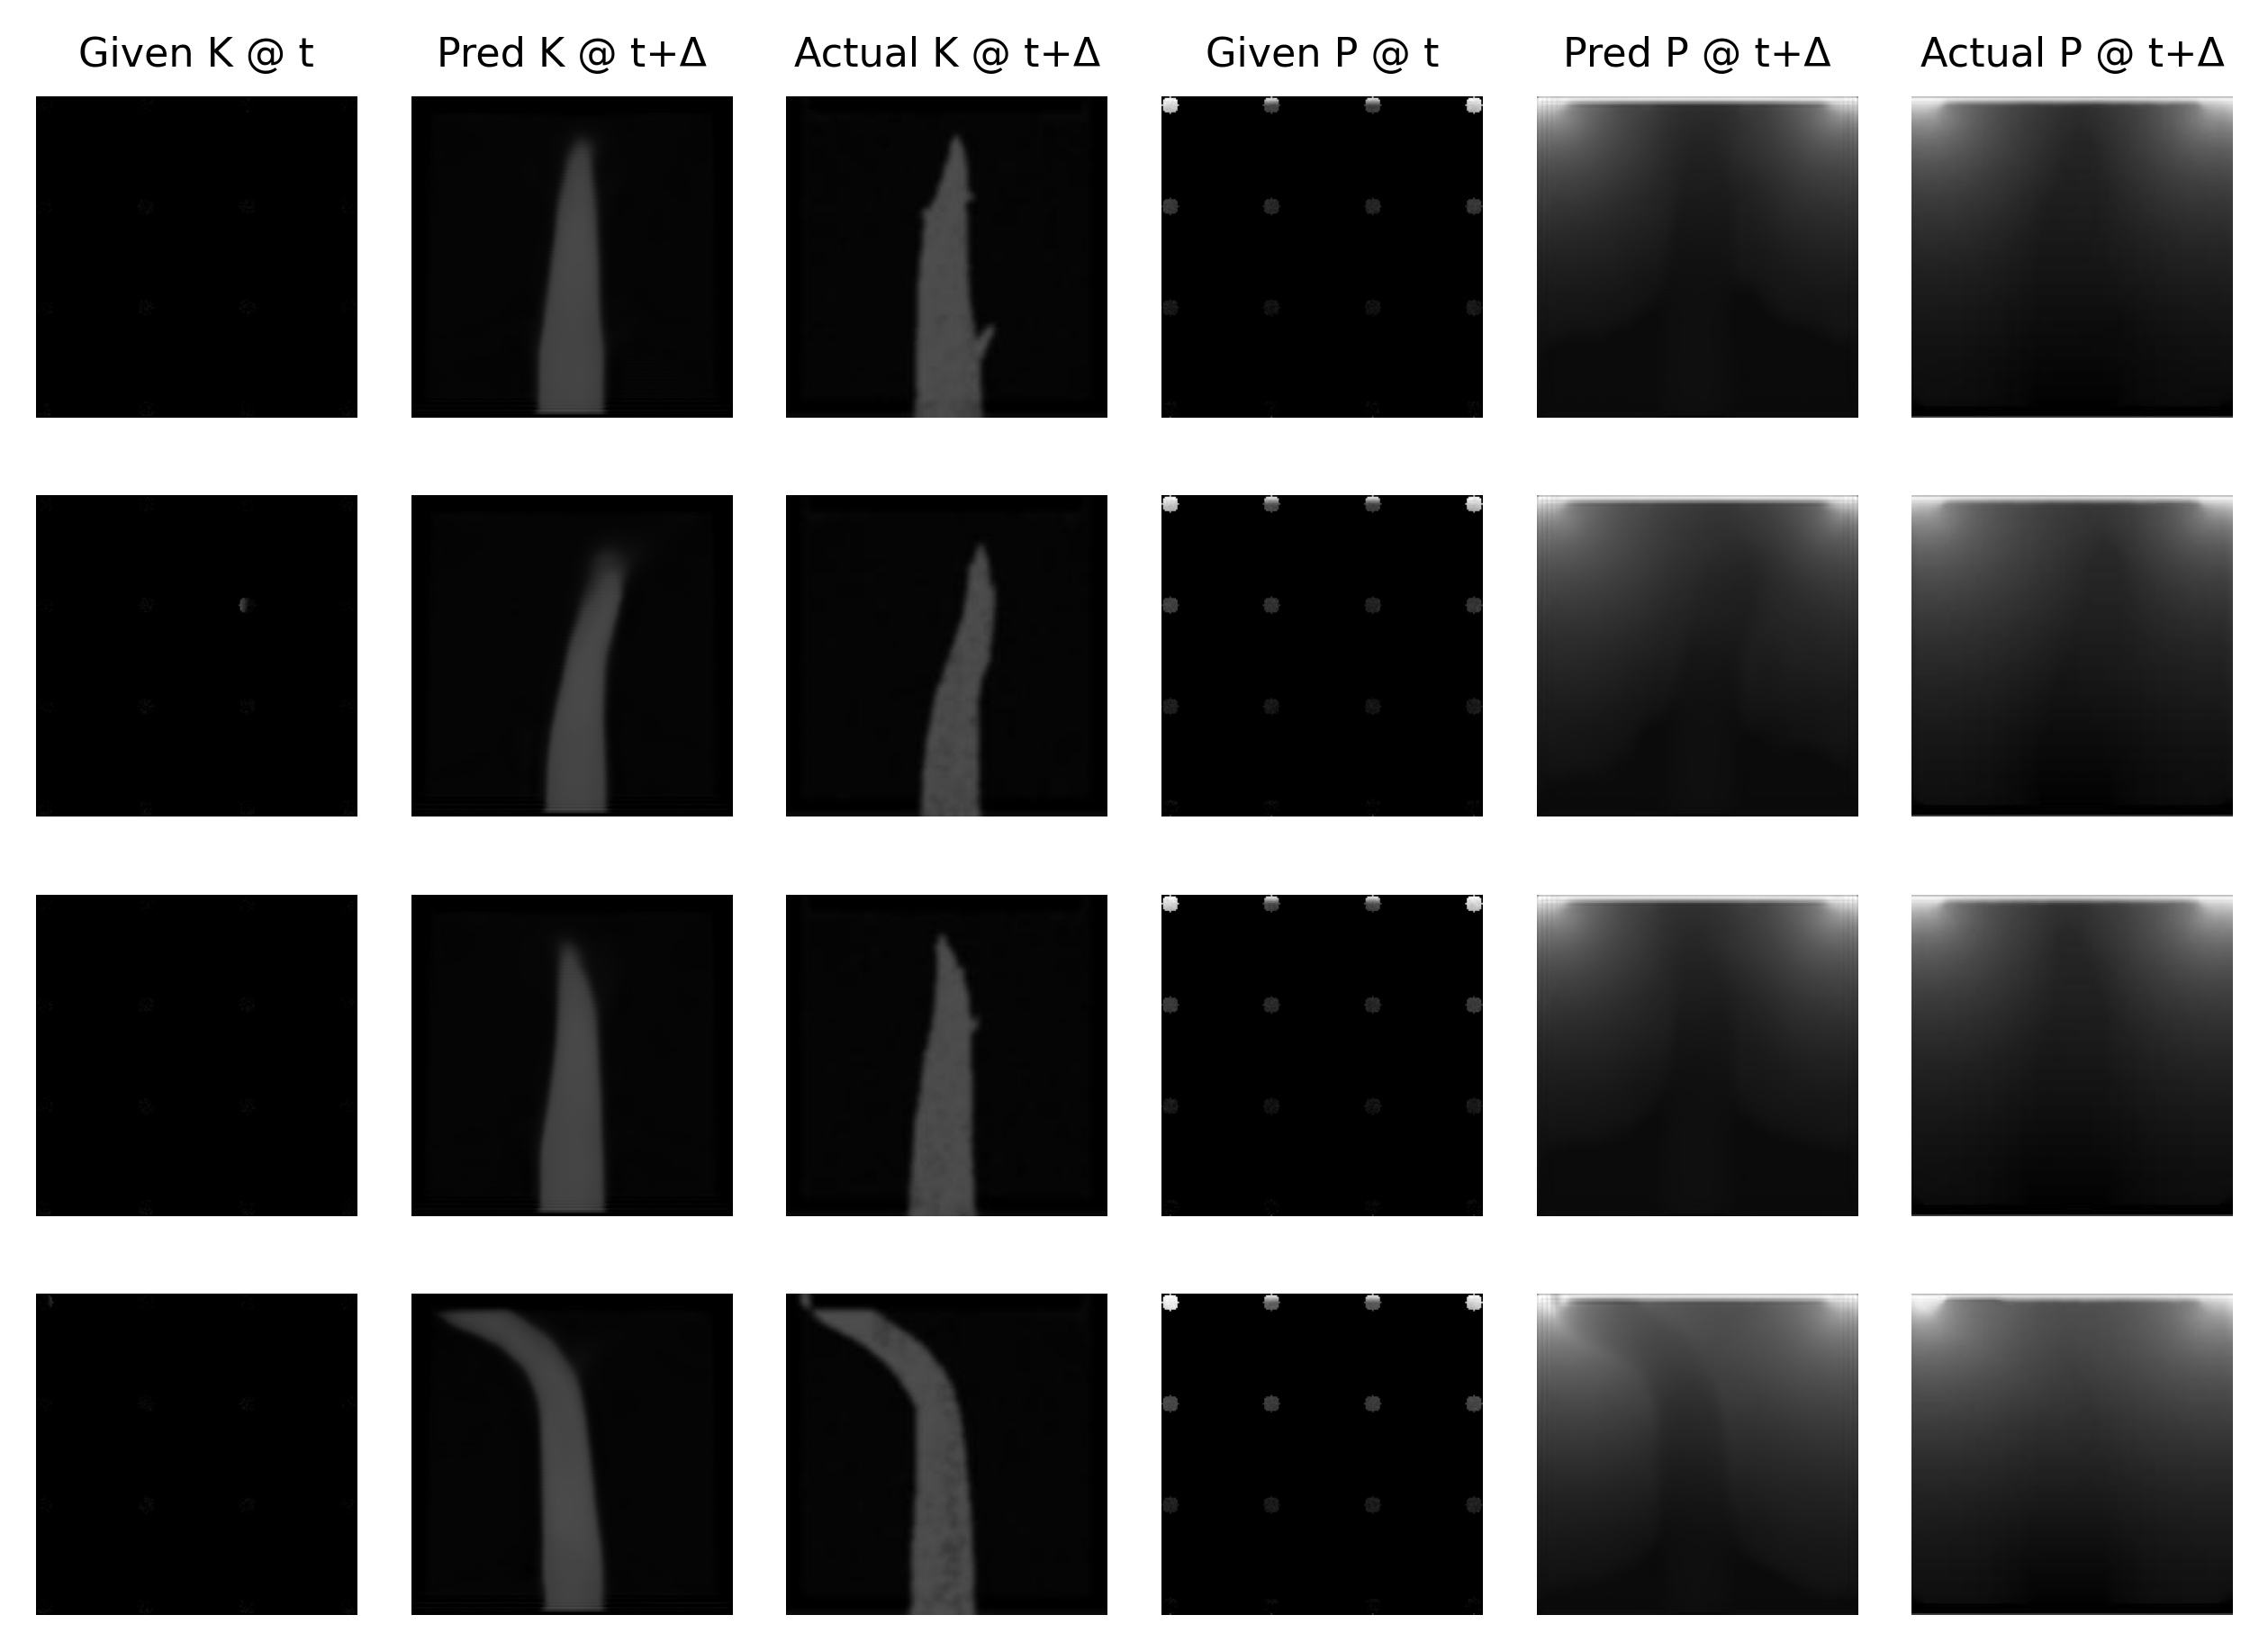

delta_10_long   L


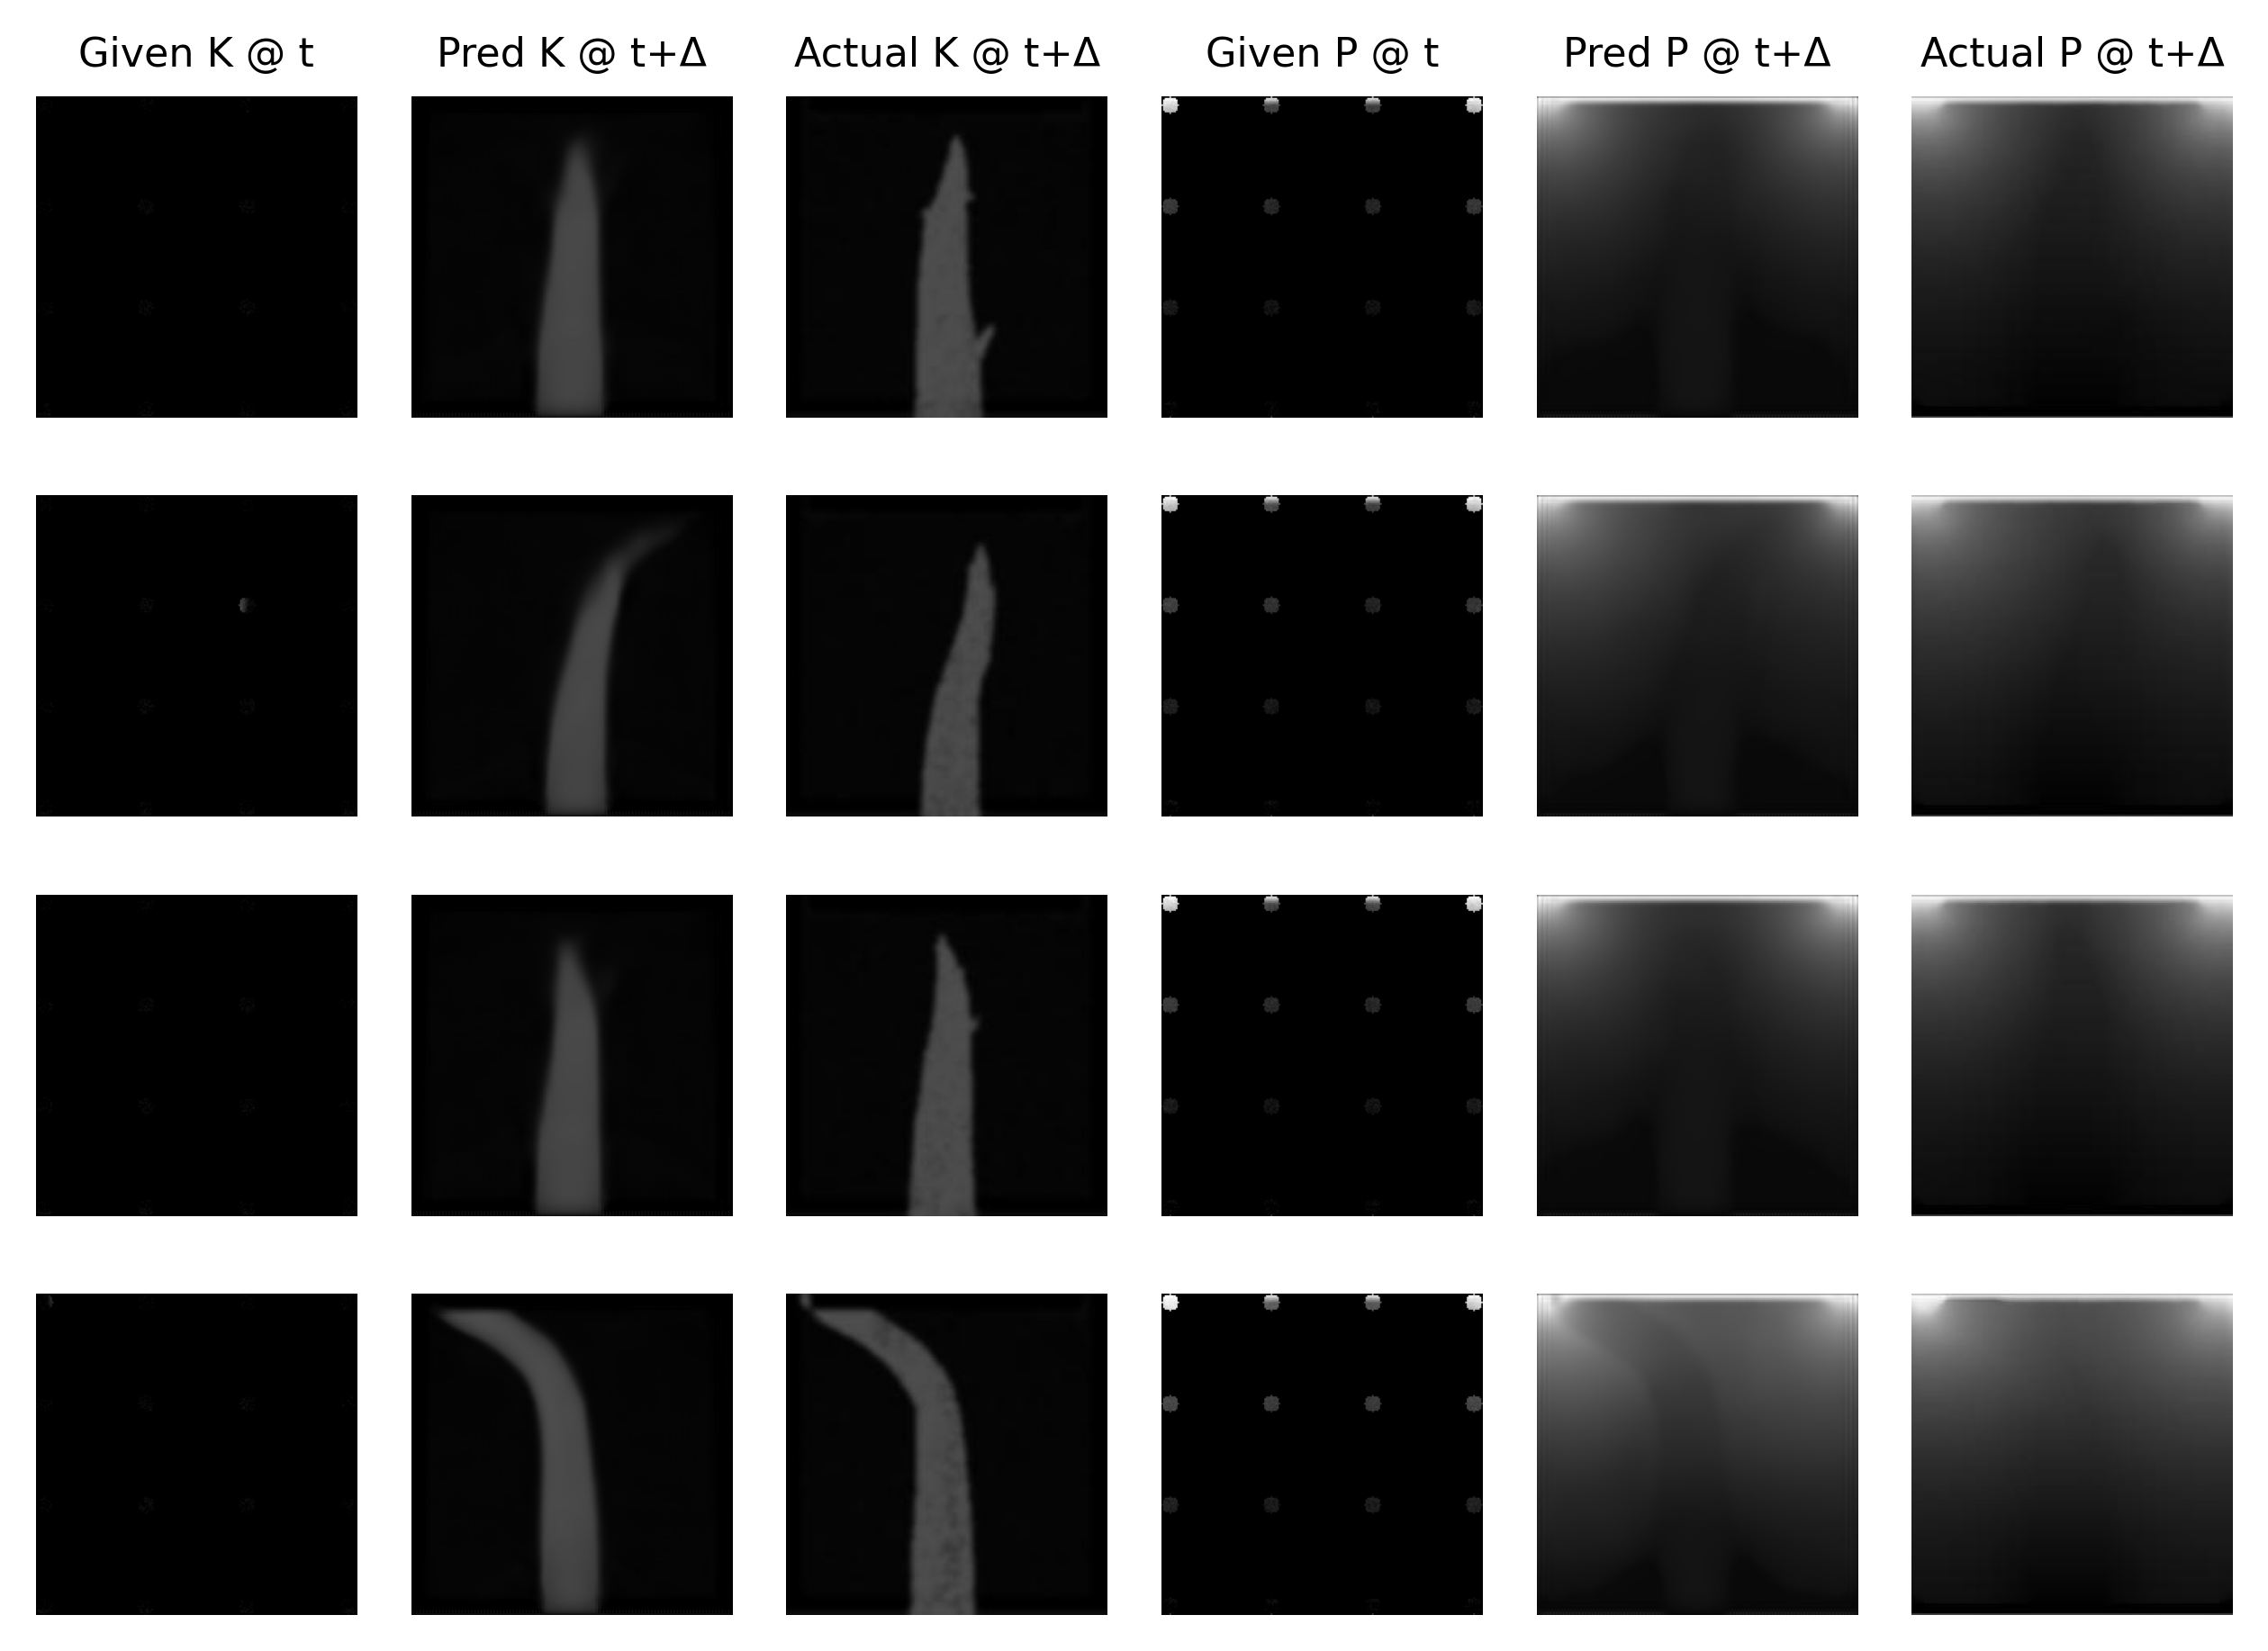

delta_20_verylong   L


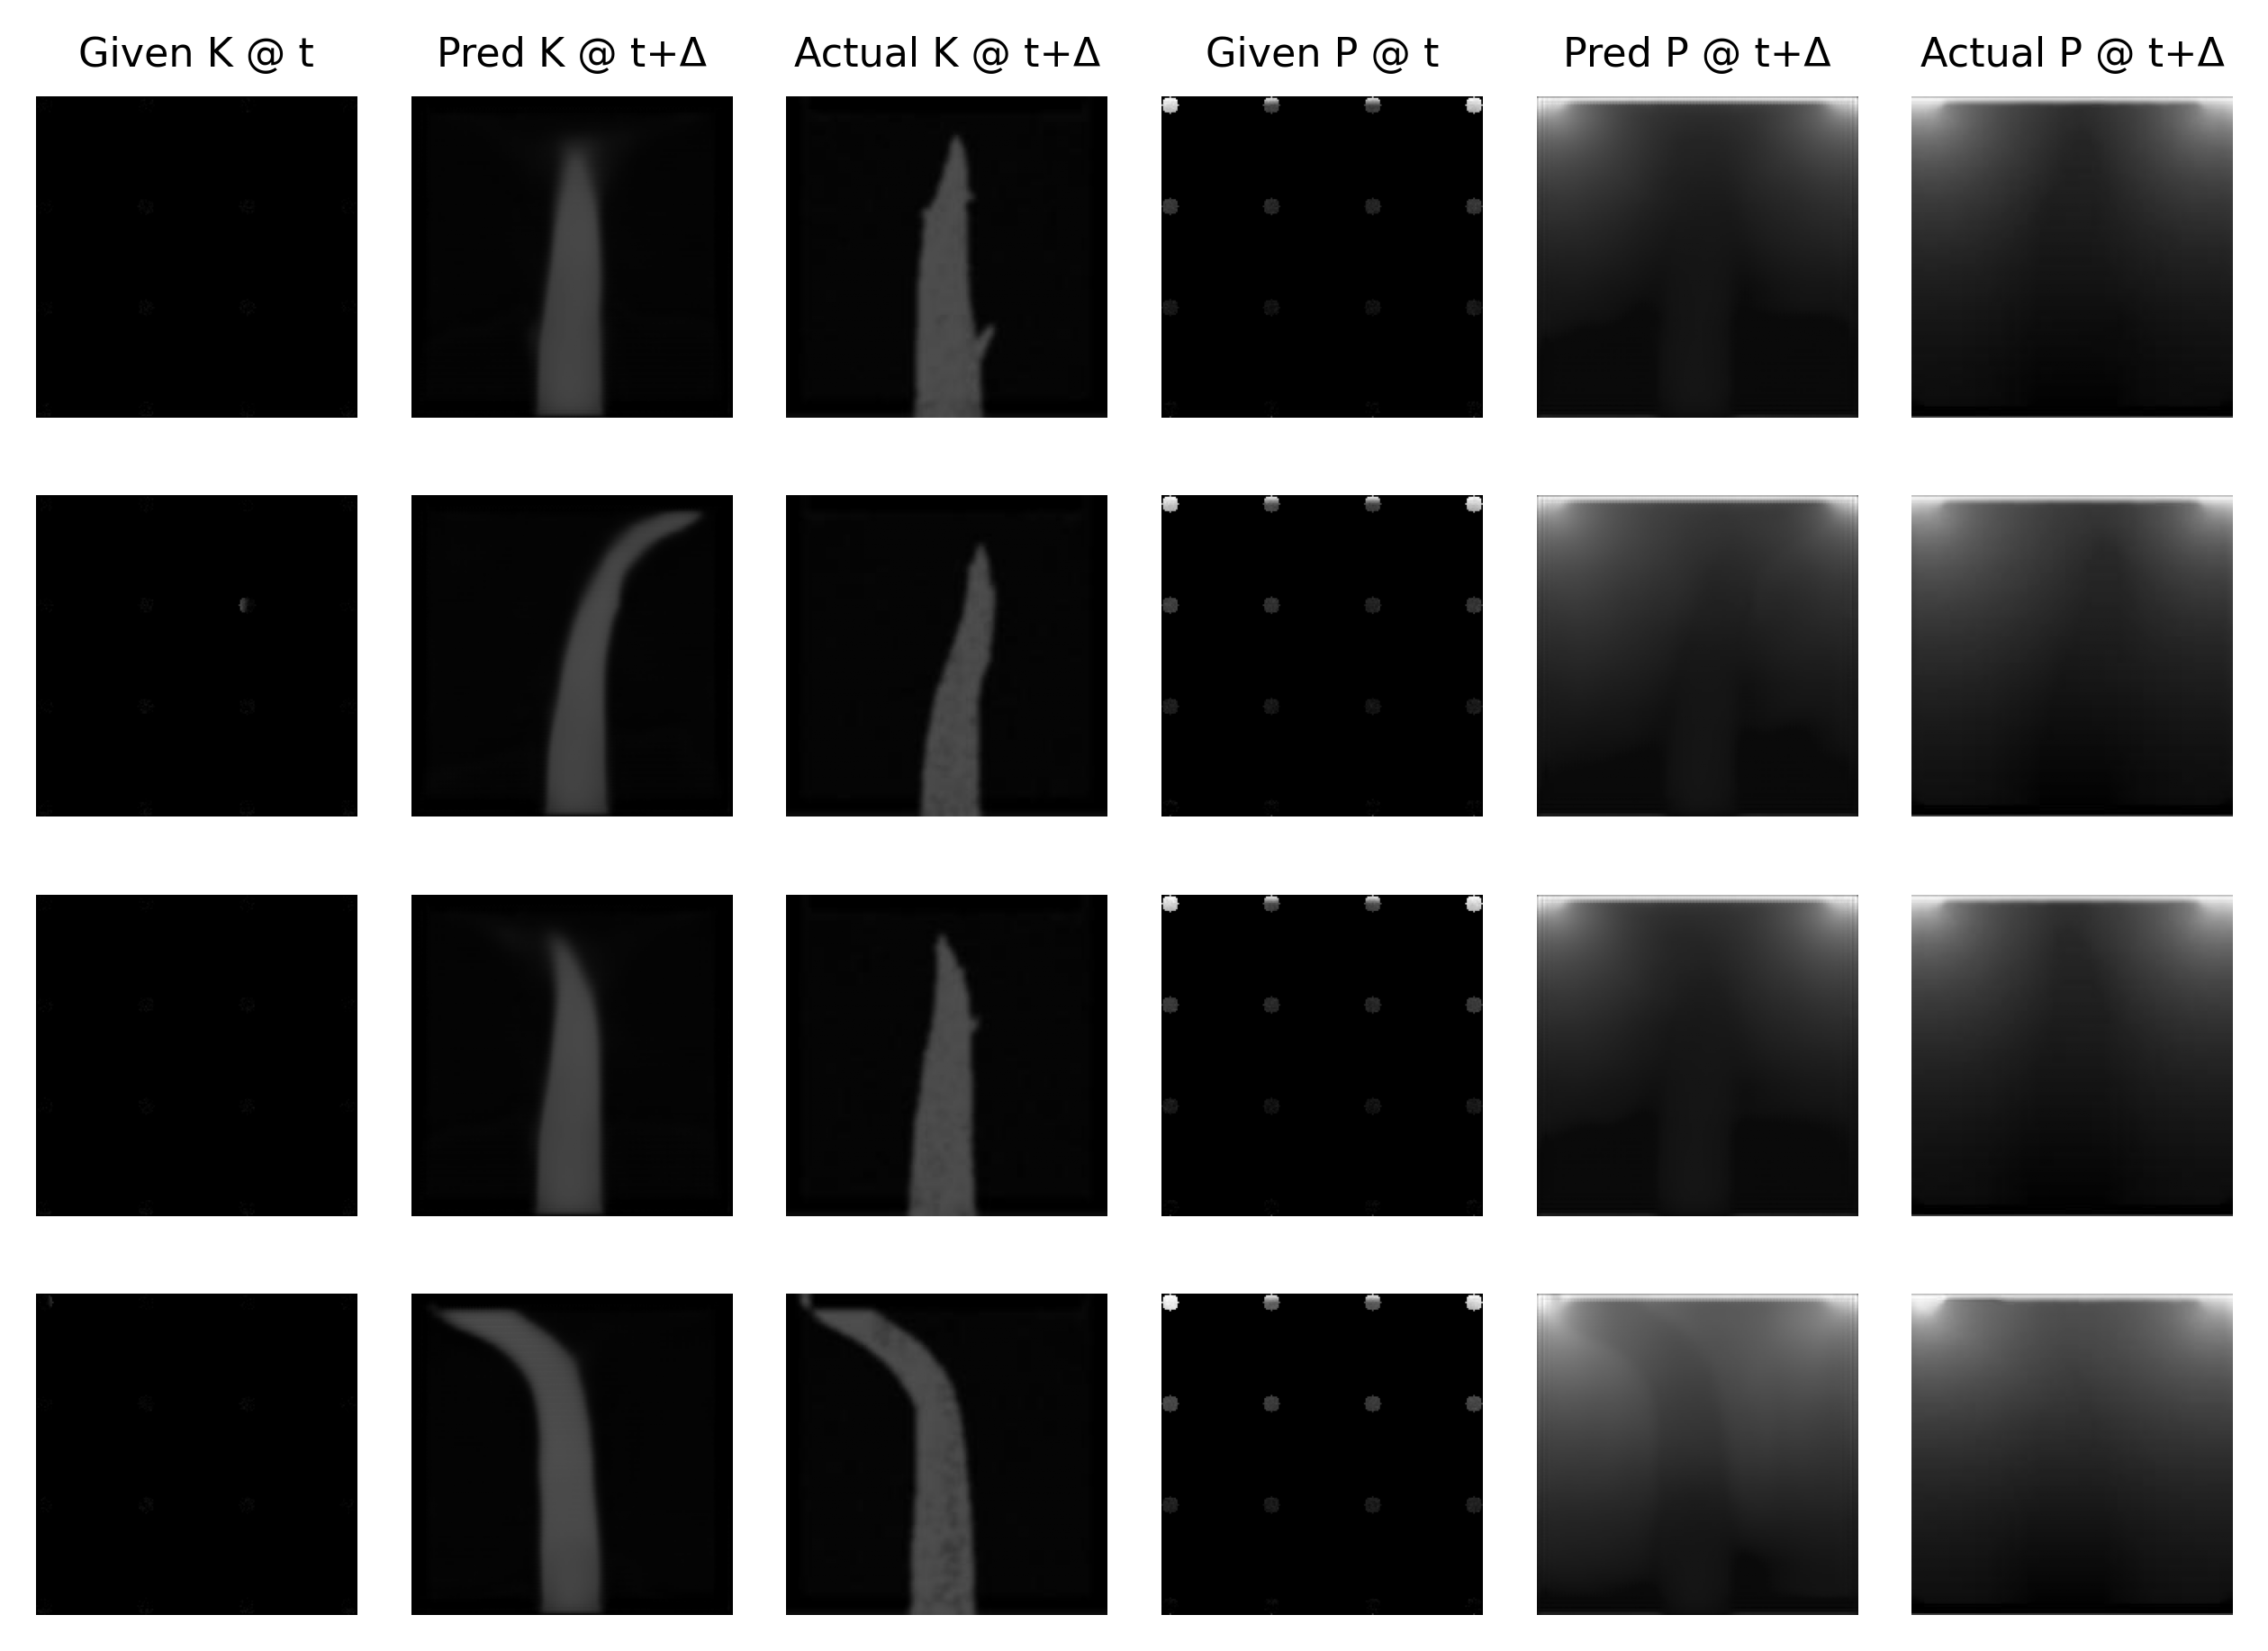

delta_40_verylong   L


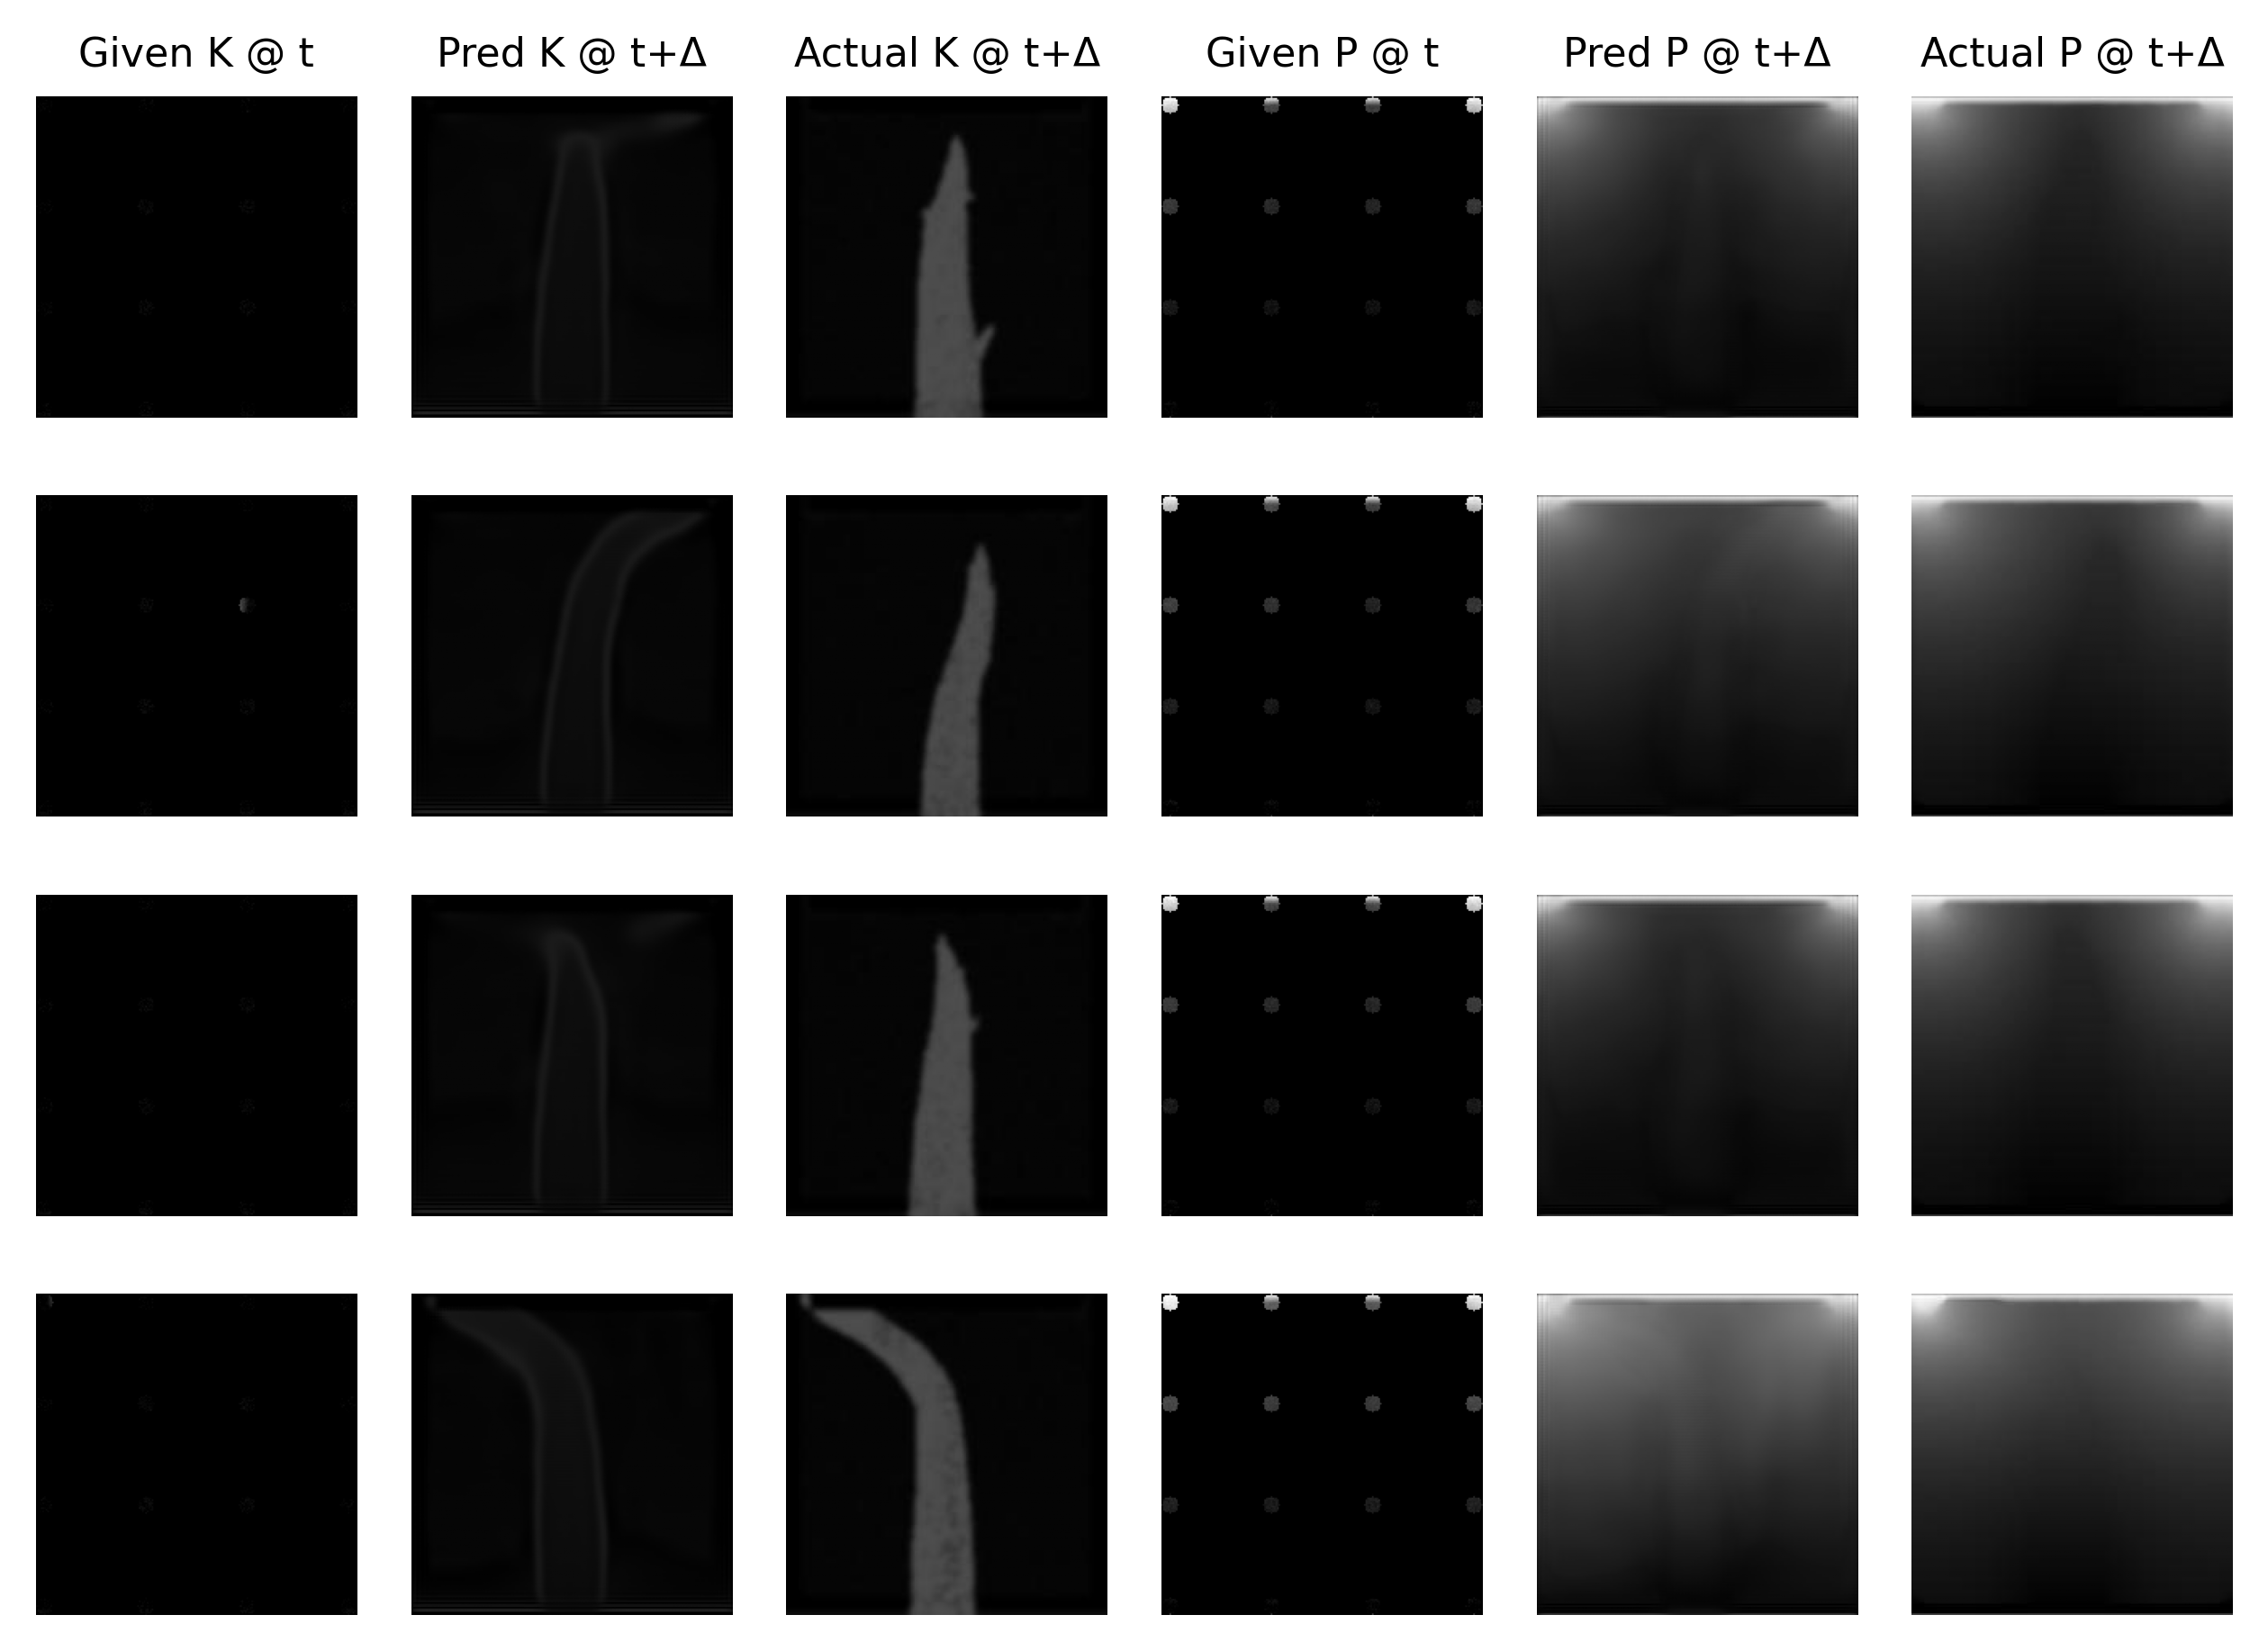

delta_60_verylong   L


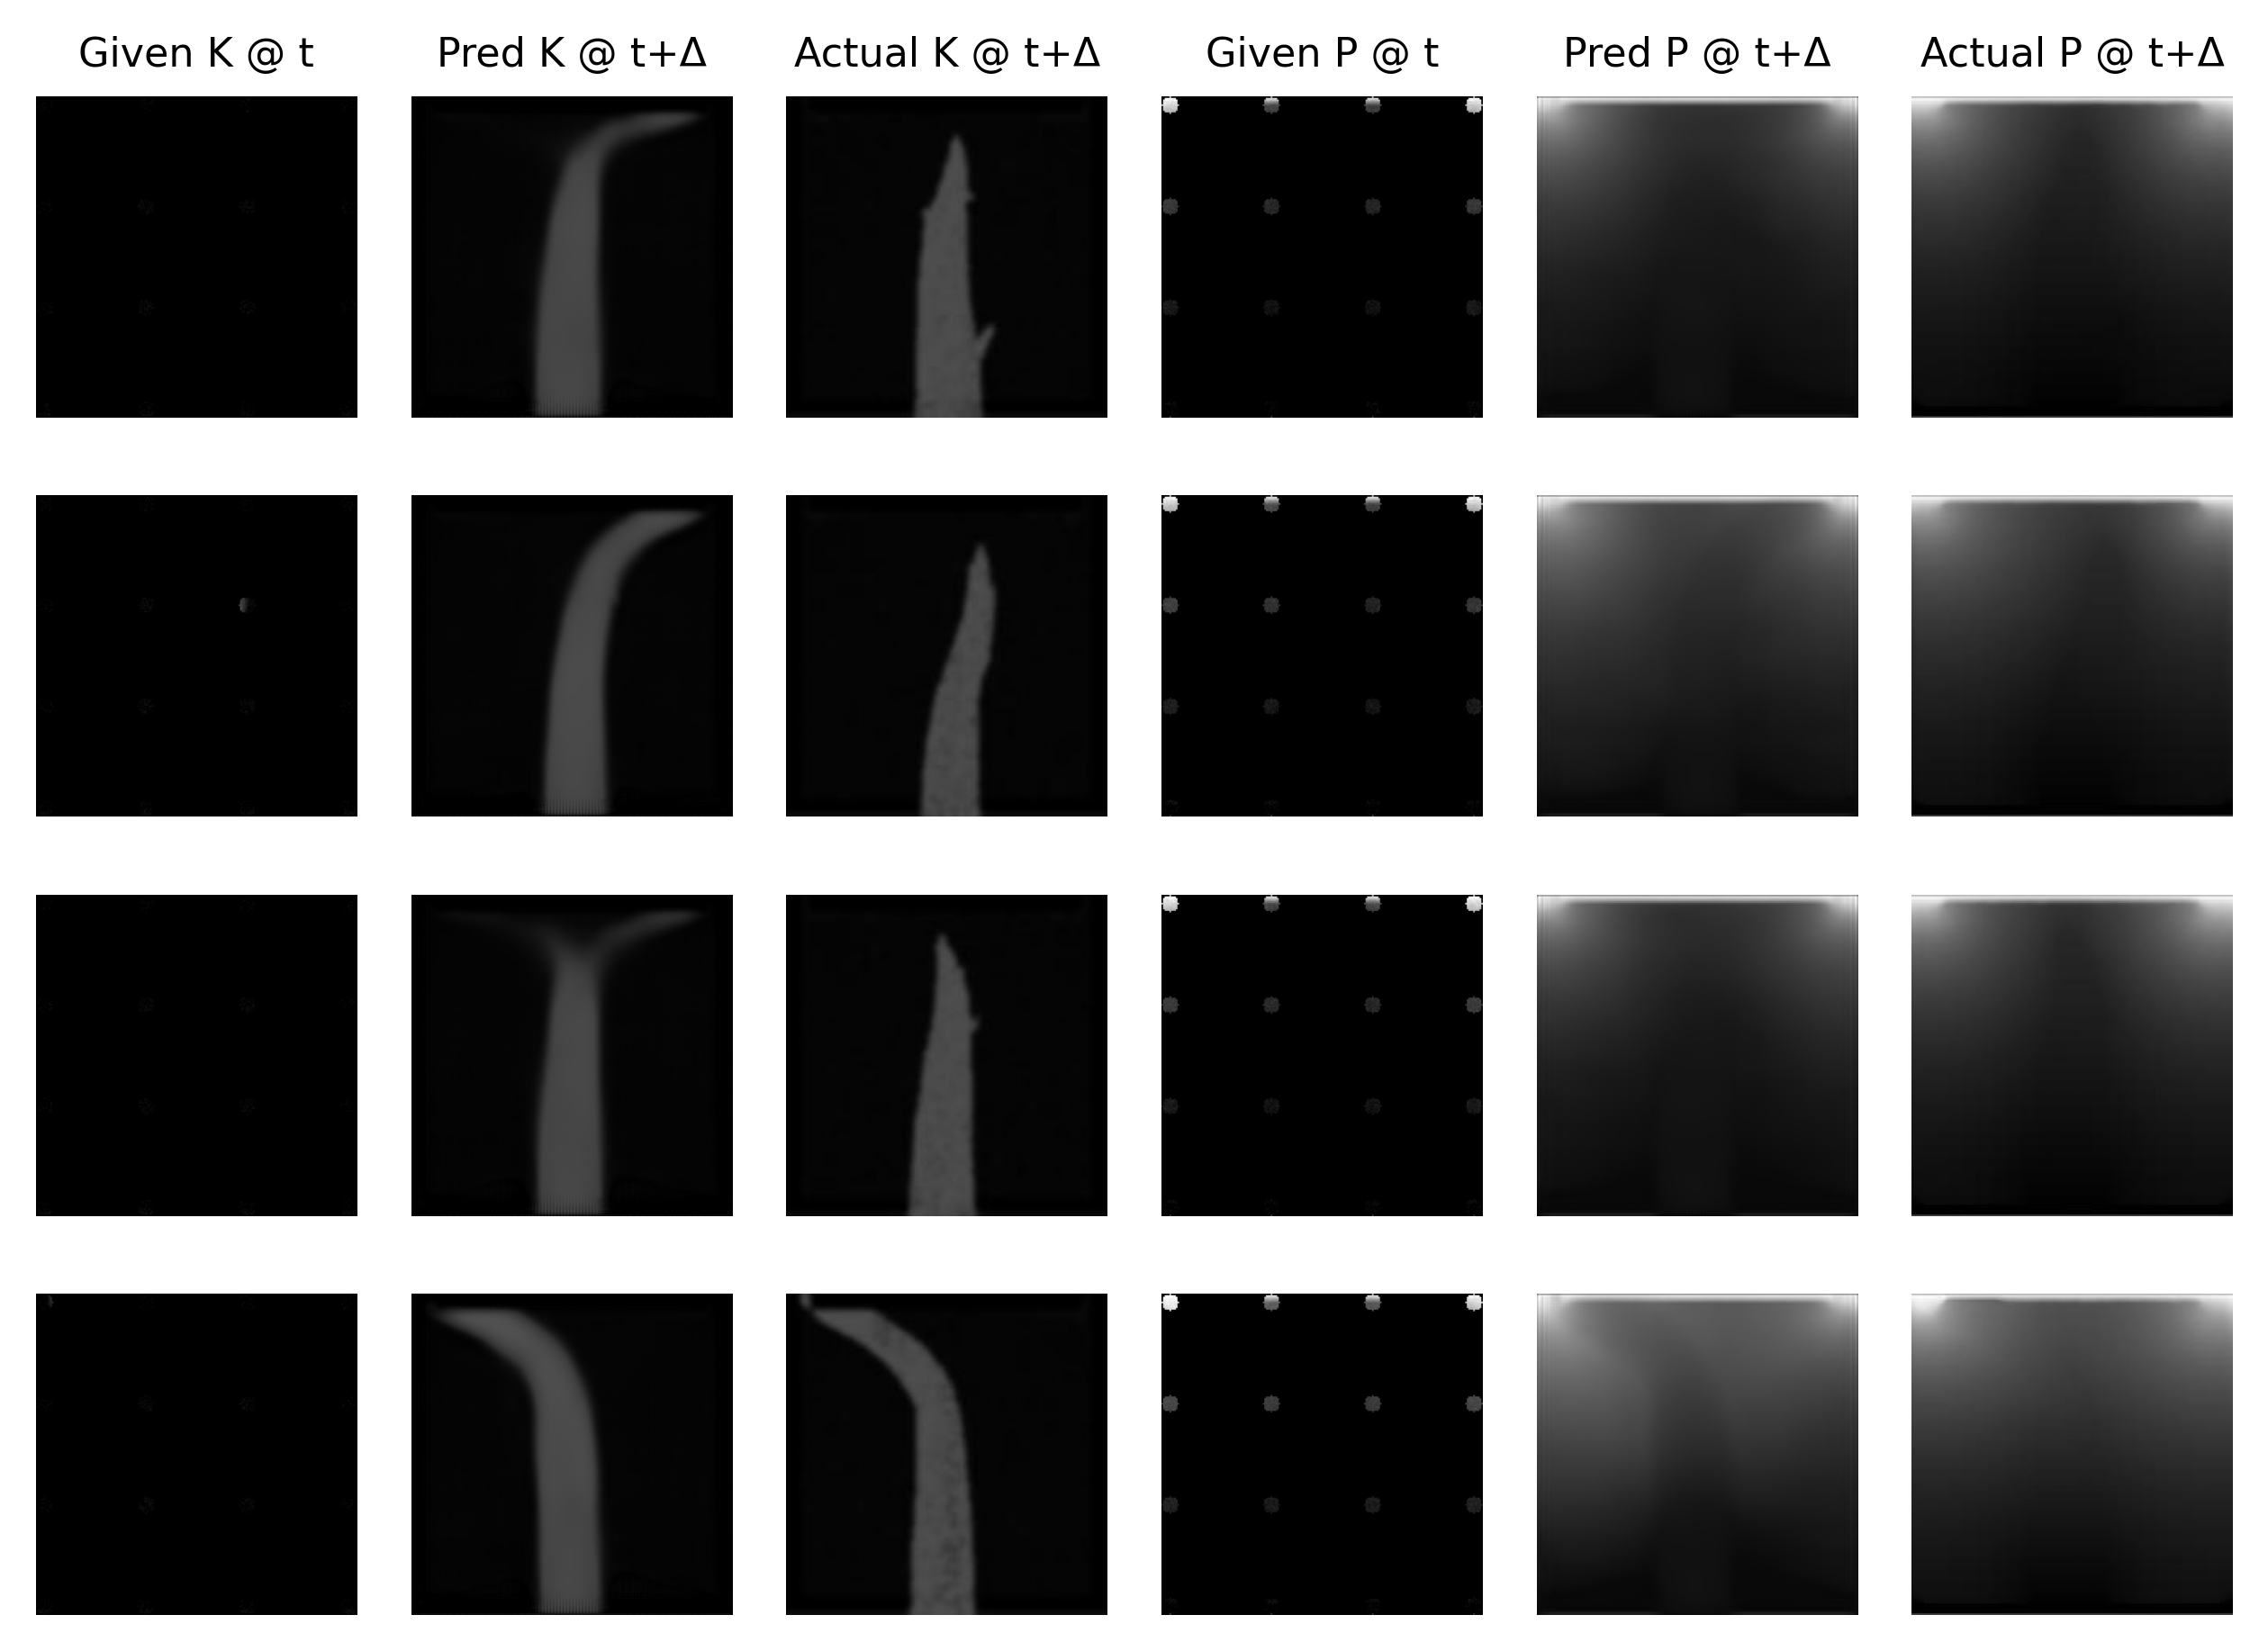

In [ ]:



for test in all_files:
    if os.path.isfile(f"{path}{test}.pt"):
        print(test + "   L")
        plot(path, test)
    else:
        print(f"{path}{test}")
